<a href="https://colab.research.google.com/github/AntonioSanabria26/Proyectos/blob/main/Prueba_serie_de_tiempo_BIMBO_A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **BIBLIOTECAS UTILIZADAS**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf, pacf

import pandas.util.testing as tm

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline

# **LECTURA DEL DF**

In [ ]:
# ARCHIVO CSV CON LOS ARCHIVOS DIARIOS DESDE EL LA FECHA 29-01-1999 hasta 23-02-2021
URL= "https://raw.githubusercontent.com/AntonioSanabria26/Proyectos/main/Datos%20historicos%20PREDICCION/Datos%20hist%C3%B3ricos%20BIMBOA.csv"

df = pd.read_csv(URL)

# RENOMBRANDO COLUMNAS
df.columns = ['Fecha', 'Cierre', 'Apertura', 'Max', 'Min',"Vol","Var"]

# CONVIRTIENDO LA FECHA Y PONIENDOLO ACENDENTE
df["Fecha"] = pd.to_datetime(df["Fecha"],dayfirst=True).copy()
df["Año"] = df["Fecha"].dt.year
df["Mes"] =df["Fecha"].dt.month
df = df.sort_values("Fecha",ascending=True)

# CONVIRTIENDO LOS MESES A CARACTERES
df.drop('Mes', axis=1, inplace=True)
df['Mes'] = df['Fecha'].dt.strftime('%b')

# CONVIRTIENDO LA FECHA COMO SERIE DE TIEMPO
df = df.set_index("Fecha")
df = df.fillna(method='ffill')


df=df.dropna()
df.to_csv('TSLA_TRATADO.csv')
df

,Cierre,Apertura,Max,Min,Vol,Var,Año,Mes
Fecha,,,,,,,,
1999-01-29,5.213,4.765,5.322,4.741,2.94M,22.60%,1999,Jan
1999-03-02,4.659,4.717,4.727,4.620,744.14K,-10.63%,1999,Mar
1999-03-03,4.804,4.620,4.814,4.620,2.02M,3.11%,1999,Mar
1999-03-08,5.007,4.959,5.043,4.935,4.82M,4.23%,1999,Mar
1999-03-09,5.080,5.007,5.128,4.983,4.56M,1.46%,1999,Mar
...,...,...,...,...,...,...,...,...
2019-05-31,39.550,39.200,40.170,38.280,6.52M,-0.35%,2019,May
2019-06-03,39.810,39.580,40.490,38.980,2.61M,0.66%,2019,Jun
2019-06-04,40.020,39.700,40.240,39.250,2.30M,0.53%,2019,Jun


# **ANÁLISIS DE SERIE DE TIEMPO CON PANDAS**

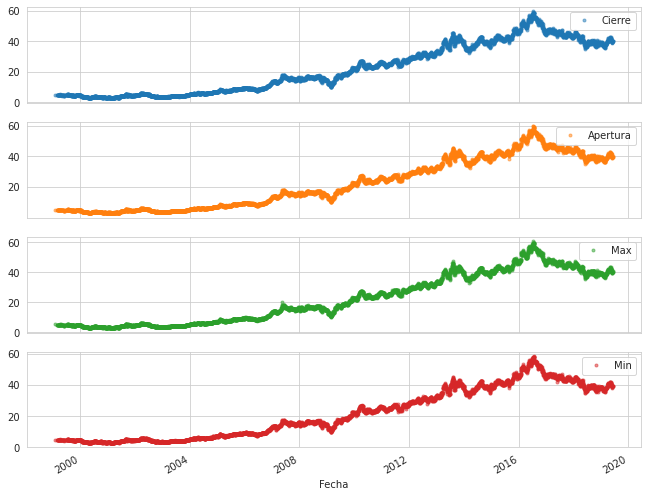

In [ ]:
#COLECCION DE DATOS DEL DATAFRAME PARA VER SI FALTAN DATOS

cols_plot = ['Cierre', 'Apertura', 'Max', 'Min',"Vol","Var"]
axes = df[cols_plot].plot(marker='.', alpha=0.5, linestyle='None',
                             figsize=(11, 9), subplots=True)

# **PRUEBA AUMENTADA DE DICKEY-FULLER (ADF) TMAX**

In [ ]:
#PRUEBA DE ESTACIONARIDAD DE UNA SERIE DE TIEMPO "TIME SERIES"
#DEFINICION DE LA FUCION PARA HACER LA PRUEBA

def test_stationarity(df_ts):

#SE DETERMIAN LA ESTADISTICA DE LOS PROMEDIOS MOVILES
    rolmean = df_ts.rolling(window=365, center=True).mean()
    rolstd = df_ts.rolling(window=365, center=True).std() 
    
#SE DEFINE EL TAMAÑO DE LA FIGURA
    plt.rcParams["figure.figsize"] = (12,6)

#GRAFICAMOS LA ESTADISTICA MOVIL
    plt.plot(df_ts, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std Deviation')
 
    plt.legend(loc='best')
    plt.title('Promedio Móvil y Desviación Estándar')
    plt.grid()
    plt.show()
 
#REALIZACION DE LA PRUEBA AUMENTADA DICKEY-FULLER
    print('Resultados de la Prueba de Dickey-Fuller:')
    dftest = adfuller(df_ts, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], 
                         index=['Test Statistic','p-value',
                                '#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [ ]:
#SE CREA LA SERIE DE TIEMPO A ANALIZAR, DONDE SE PUEDE REGRESAR
#A ESTE PUNTO TANTAS VECES SEA NECESARIA REDIFINIR

#FECHA DE INICIO Y DE FIN:
start, end = '2010-01', '2021-01'
BIMBO_TIME = df.loc[start:end].copy()
BIMBO_TIME.head()

,Cierre,Apertura,Max,Min,Vol,Var,Año,Mes
Fecha,,,,,,,,
2010-01-04,21.925,21.637,22.247,21.625,2.19M,1.33%,2010,Jan
2010-01-05,22.040,21.900,22.375,21.858,2.24M,0.52%,2010,Jan
2010-01-06,21.970,22.040,22.500,21.750,3.54M,-0.32%,2010,Jan
2010-01-07,22.122,22.122,22.280,22.000,1.75M,0.69%,2010,Jan
2010-01-08,22.062,22.125,22.125,21.990,679.60K,-0.27%,2010,Jan


In [ ]:
# DEFINIMOS LA SEIRE DE TIEMPO PARA MAX QUE VAMOS A ESTUDIAR.
# DEFINIDA CON NOMBRE GENERICO.

MAXB = BIMBO_TIME['Max'].copy()

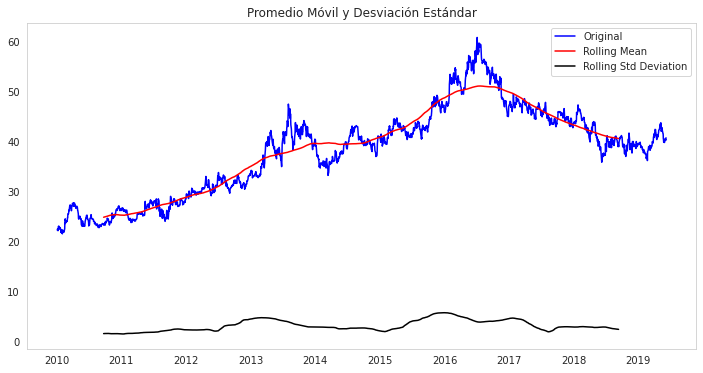

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                   -1.821550
p-value                           0.369817
#Lags Used                        8.000000
Number of Observations Used    2361.000000
Critical Value (1%)              -3.433123
Critical Value (5%)              -2.862765
Critical Value (10%)             -2.567422
dtype: float64


In [ ]:
#PRUEBA DE ESTACIONARIDAD DE TMAX
test_stationarity(MAXB)

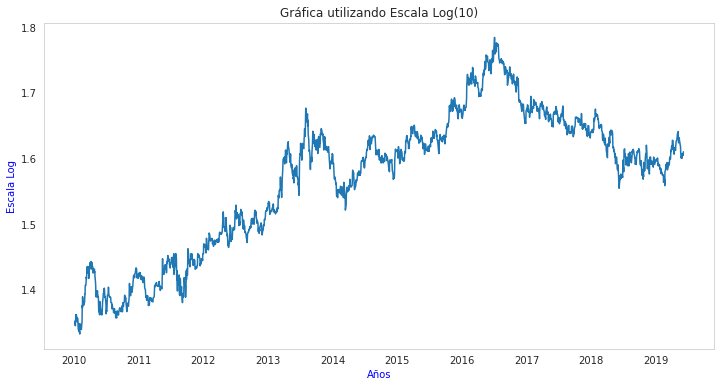

In [ ]:
# Seleccionamos la función logaritmo (base 10) y graficamos (La escala en eje-y es Log)
ts_test_log = np.log10(MAXB)
plt.plot(ts_test_log)
plt.xlabel('Años',color='b')
plt.ylabel('Escala Log',color='b')
plt.title('Gráfica utilizando Escala Log(10)')
plt.grid()
plt.show();

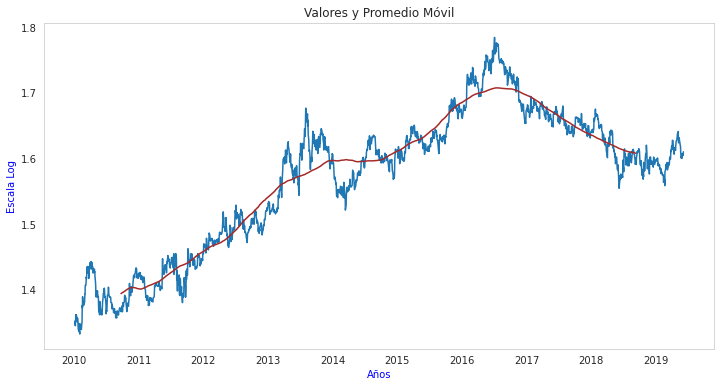

In [ ]:
# VAMOS A CALCULAR EL PROMEDIO MOVIL DE ts_test_log CON VENTANA DE 365
# PARA VER EL CONTRASTE CON LA DE ARRIBA.

moving_avg = ts_test_log.rolling(365, center=True).mean()
plt.plot(ts_test_log)
plt.plot(moving_avg, color = 'brown')
plt.xlabel('Años',color='b')
plt.ylabel('Escala Log',color='b')
plt.title('Valores y Promedio Móvil')
plt.grid()
plt.show();

In [ ]:

ts_test_log_moving_ave_diff = ts_test_log - moving_avg 
ts_test_log_moving_ave_diff.head()

Fecha
2010-01-04   NaN
2010-01-05   NaN
2010-01-06   NaN
2010-01-07   NaN
2010-01-08   NaN
Name: Max, dtype: float64

In [ ]:

ts_test_log_moving_ave_diff.dropna(inplace=True)
ts_test_log_moving_ave_diff.head()

Fecha
2010-09-23   -0.027572
2010-09-24   -0.025344
2010-09-27   -0.025946
2010-09-28   -0.022361
2010-09-29   -0.022162
Name: Max, dtype: float64

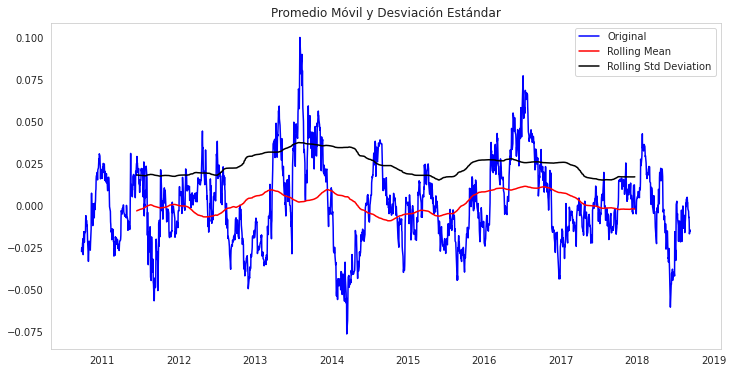

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                   -4.568360
p-value                           0.000148
#Lags Used                        8.000000
Number of Observations Used    1997.000000
Critical Value (1%)              -3.433629
Critical Value (5%)              -2.862988
Critical Value (10%)             -2.567541
dtype: float64


In [ ]:

#AHORA LA ESTACIONARIDAD ESTARA ESCALADA EN LOG
test_stationarity(ts_test_log_moving_ave_diff)

# **PRUEBA AUMENTADA DE ARIMA TMAX**

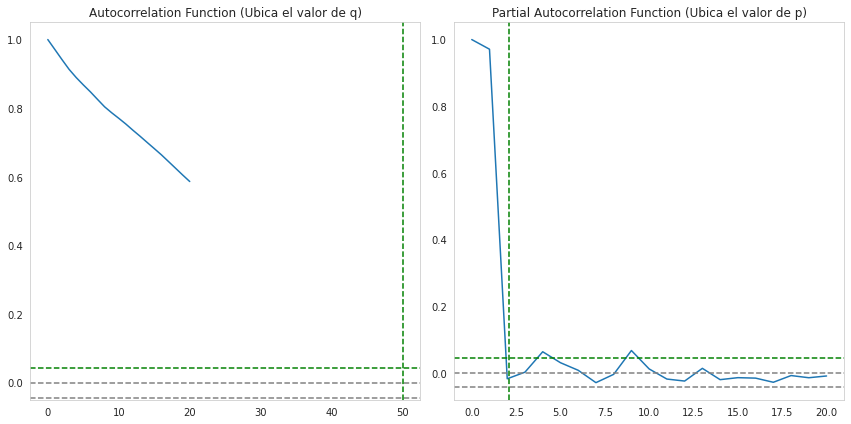

In [ ]:
#Aplicamos ARIMA

lag_acf = acf(ts_test_log_moving_ave_diff, nlags=20)
lag_pacf = pacf(ts_test_log_moving_ave_diff, nlags=20, method = 'ols')

# Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)

# Gráfica de ACF (Autocorrelation Function)
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_test_log_moving_ave_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_test_log_moving_ave_diff)), linestyle='--', color='green')

# Graficamos unas líneas verticales como referencias
plt.axvline(x=50, linestyle='--', color='green')
plt.grid()
plt.title('Autocorrelation Function (Ubica el valor de q)')

# Gráfica de PACF (Partial Autocorrelation Function)
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_test_log_moving_ave_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_test_log_moving_ave_diff)), linestyle='--', color='green')
# Graficamos unas líneas verticales como referencias 
plt.axvline(x=2.1, linestyle='--', color='green')
plt.grid()
plt.title('Partial Autocorrelation Function (Ubica el valor de p)')

plt.tight_layout()

In [ ]:

# MODELO DE ARIMA (AUTO-REGRESION + PROMEDIO MOVIL)
# Modelo ARIMA(p): (p,d,q) = (2,1,20) 
model = ARIMA(ts_test_log_moving_ave_diff, order=(2,1,50), missing='drop')
results_ARIMA = model.fit(displ=-1)
plt.plot(ts_test_log_moving_ave_diff)
plt.plot(results_ARIMA.fittedvalues, color='brown')
plt.title('ARIMA(2,1,4) = AR(2) + MA(4)')
print(results_ARIMA.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:811: RuntimeWarning: invalid value encountered in double_scalars
  llf = -nobs/2.*(log(2*pi) + log(sigma2)) - ssr/(2*sigma2)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: in